In [1]:
!make -C .. calibrate_ucm

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'calibrate_ucm'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [2]:
import json
import tempfile

import numpy as np
import pandas as pd
import seaborn as sns

from invest_heat_islands import plot_utils
from invest_heat_islands.invest import utils

In [3]:
calibration_log_filepath = '../data/interim/invest/calibration-log.json'

agglom_lulc_filepath = '../data/raw/agglom-lulc.tif'
aoi_vector_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
biophysical_table_filepath = '../data/interim/biophysical-table-shade.csv'
ref_et_filepath = '../data/interim/ref-et.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'
station_tair_filepath = '../data/interim/station-tair.csv'

In [4]:
with open(calibration_log_filepath) as src:
    calibration_log = json.load(src)
    model_params = calibration_log['args']
    rmses = calibration_log['rmses']
model_params

{'t_air_average_radius': 334.29676056419675,
 'green_area_cooling_distance': 50.28513598142648,
 'cc_weight_shade': 0.45714574056524665,
 'cc_weight_albedo': 0.1976526578371854,
 'cc_weight_eti': 0.34520160159756796}

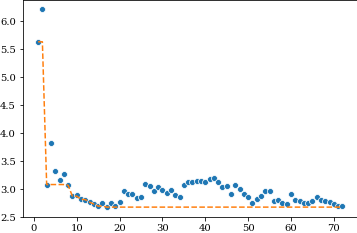

In [5]:
rmse_df = pd.DataFrame()
rmse_df['rmse'] = pd.Series(rmses,
                            index=pd.RangeIndex(start=1, stop=len(rmses) + 1))
rmse_df['cummin'] = rmse_df['rmse'].cummin()
iter_idx = rmse_df.index
color_palette = iter(sns.color_palette())
ax = sns.scatterplot(iter_idx,
                     rmse_df['rmse'].rename(),
                     color=next(color_palette))
rmse_df['cummin'].plot(ax=ax,
                       style='--',
                       color=next(color_palette),
                       label='Best RMSE')

In [6]:
station_location_df = pd.read_csv(station_locations_filepath, index_col=0)
station_tair_df = pd.read_csv(station_tair_filepath, index_col=0)
station_tair_df.index = pd.to_datetime(station_tair_df.index)

mw = utils.ModelWrapper(    
    agglom_lulc_filepath,
    biophysical_table_filepath,
    ref_et_filepath,
    aoi_vector_filepath,
    station_tair_filepath,
    station_locations_filepath,
    model_params=model_params)

In [7]:
comparison_df = mw.get_comparison_df()
comparison_df['err'] = comparison_df['pred'] - comparison_df['obs']
comparison_df['sq_err'] = comparison_df['err']**2
comparison_df['elev'] = comparison_df['station'].apply(
    lambda stn: station_location_df.loc[stn, 'alt'])

In [8]:
mse = comparison_df['sq_err'].mean()
rmse = np.sqrt(mse)
print('Mean squared error:', mse)
print('Root mean squared error:', np.sqrt(mse))

Mean squared error: 2.6766282858274275
Root mean squared error: 1.6360404291543127


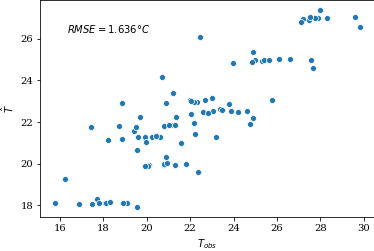

In [9]:
fig = plot_utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-pred-obs.pdf')

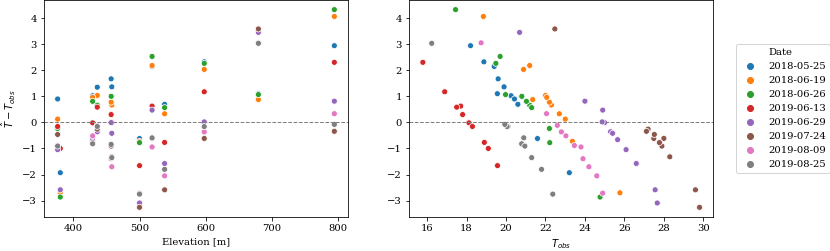

In [10]:
fig = plot_utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-errors.pdf')

### Plotting the maps simulated by the calibrated urban cooling model

In [11]:
!make -C .. tair_ucm_maps

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'tair_ucm_maps'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [12]:
T_ucm_da = mw.predict_T_da()

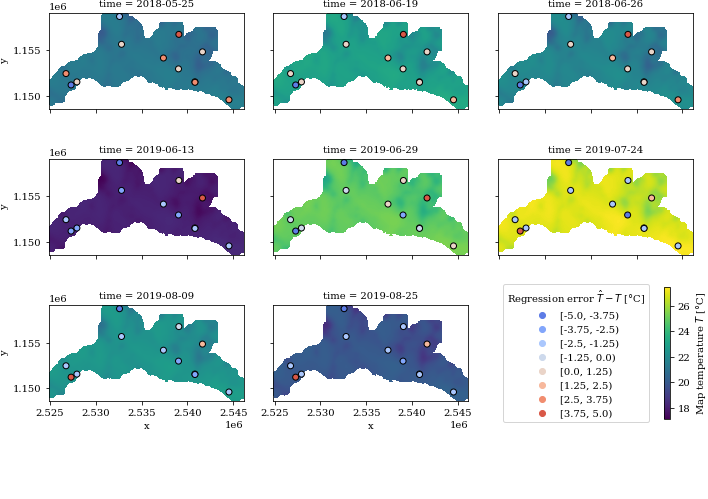

In [13]:
g = plot_utils.plot_T_maps(T_ucm_da,
                           station_location_df,
                           comparison_df=comparison_df)
g.fig.savefig('../reports/figures/invest-ucm-maps.png')